# Определение возраста покупателей

## Цели и описание проекта

### Описание проекта: Определение возраста покупателей  

**Цель данного проекта** — разработать модель для предсказания возраста покупателей по их фотографиям. Это позволит сети супермаркетов «Хлеб-Соль»:  
1. Анализировать покупки и предлагать персонализированные товары для различных возрастных групп.  
2. Контролировать корректность работы кассиров при продаже алкоголя.  

Использование компьютерного зрения и нейронных сетей для автоматического определения возраста повысит эффективность маркетинговых стратегий и поможет соблюдать законодательные требования.  

### **Цель исследования**  
Разработать и обучить нейронную сеть, способную определять возраст человека по фотографии. Для этого будет проведен анализ данных, подготовка изображений, обучение модели и оценка её качества.  

### **Основные этапы проекта**  

- Исследовательский анализ данных: анализ распределения возрастов, проверка наличия выбросов, оценка структуры выборки.
- Подготовка данных: нормализация, аугментация, разбиение на обучающую и валидационную выборки.
- Обучение модели: применение ResNet50 с предобученными весами, настройка гиперпараметров.
- Оценка качества: анализ ошибок предсказаний, метрики качества MAE.
- Выводы и рекомендации: возможности улучшения модели, анализ ошибок, дальнейшие шаги.


## Исследовательский анализ данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
# Загружаем CSV-файл с данными
labels = pd.read_csv('/datasets/faces/labels.csv')
path = '/datasets/faces/'

datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    )

data_generator = datagen.flow_from_dataframe(
    dataframe=pd.read_csv(path+'labels.csv'),
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    batch_size=32,
    class_mode='raw',



)


Found 7591 validated image filenames.


загрузчик фотографий успешно создан

In [ ]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


csv  файл labels содержит наименование фотографии и таргет (возраст человека на фотографии)

In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Возраст людей на фотографии адекватный от 1 года до 100 лет, средний возраст людей в датасете 31 лет

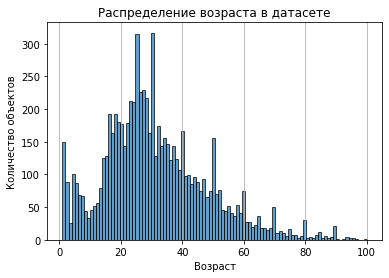

In [ ]:
labels['real_age'].hist(bins=100, edgecolor='black', alpha=0.7)

plt.title("Распределение возраста в датасете")
plt.xlabel("Возраст")
plt.ylabel("Количество объектов")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

- большая часть значений сосредоточена в более молодом возрасте, но есть и небольшое количество пожилых людей.
- основная масса данных сконцентрирована в диапазоне от 20 до 41 лет
- данные имеют асимметричное (правостороннее) распределение
- на распределении видны пики в значениях 40, 50, 60 и т.д., что говорит о возможном округлении возрастов на части датасета

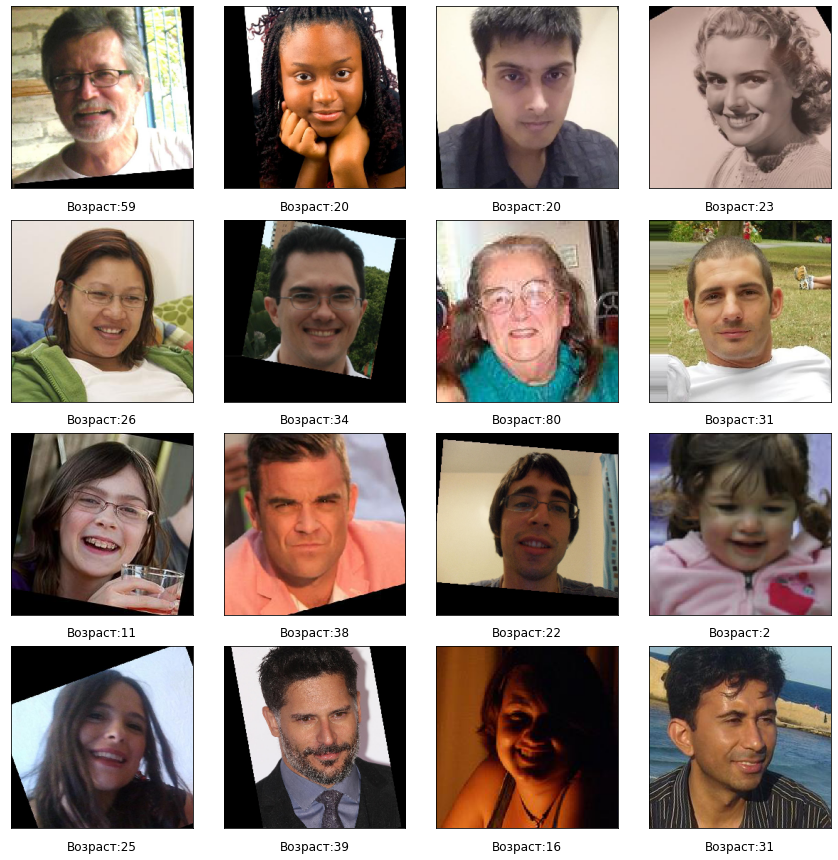

In [ ]:
features, target = next(data_generator)
# выводим 16 изображений
fig = plt.figure(figsize=(12,12))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(features[i])

    # Добавляем возраст под изображением
    ax.text(0.5, -0.1, 'Возраст:' + str(target[i]), ha='center', va='center', transform=ax.transAxes, fontsize=12)

    # Убираем оси
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

- Выведены 16 случайных фотографий с возрастом человека на фотографии
- фотографии имеют разное качество изображений (разрешение, освещение, цветность, контраст)
- фотографии имеют различные ракурсы лица
- на некоторых фотографиях есть темный фон
- фотографии имеют разную освещенность
- на некоторых фотографиях человек расположен далеко.

## Обучение модели

Принято решение использовать предобученная модель на основе ResNet50

```python

# функция загрузки данных
def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        rotation_range=30,
        brightness_range=[0.5, 1.5],
        zoom_range=0.2

    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory = path +'/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    validation_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    train_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory = path+'/final_files',
        x_col='file_name',
        y_col='real_age',        
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return train_datagen_flow


# функция создания модели
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)

    backbone = ResNet50(
        input_shape=(224, 224, 3),
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False,
        )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))



    model.compile(optimizer=optimizer, loss='mean_absolute_error',
                  metrics=['mae'])

    return model


# функция обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=30,
               steps_per_epoch=None, validation_steps=None):
  
    early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)


    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=[early_stopping],
              verbose=2,
              shuffle=True)

    return model

path = '/datasets/faces/'
train = load_train(path)
test = load_test(path)
model = create_model((224, 224, 3))
train_model(model, train, test, epochs=30)
```

метрика МАЕ данной модели составила 6,1 лет

```
Epoch 1/30
178/178 - 127s - loss: 12.4906 - mae: 12.4916 - val_loss: 23.4714 - val_mae: 23.4785
Epoch 2/30
178/178 - 117s - loss: 8.3945 - mae: 8.3944 - val_loss: 19.2918 - val_mae: 19.2738
Epoch 3/30
178/178 - 122s - loss: 7.7382 - mae: 7.7387 - val_loss: 11.1135 - val_mae: 11.0856
Epoch 4/30
178/178 - 122s - loss: 7.2755 - mae: 7.2761 - val_loss: 8.2382 - val_mae: 8.2397
Epoch 5/30
178/178 - 122s - loss: 6.8127 - mae: 6.8134 - val_loss: 7.3829 - val_mae: 7.3904
Epoch 6/30
178/178 - 123s - loss: 6.5759 - mae: 6.5763 - val_loss: 7.0702 - val_mae: 7.0946
Epoch 7/30
178/178 - 122s - loss: 6.3128 - mae: 6.3131 - val_loss: 7.3123 - val_mae: 7.3482
Epoch 8/30
178/178 - 123s - loss: 6.1637 - mae: 6.1638 - val_loss: 6.5524 - val_mae: 6.5754
Epoch 9/30
178/178 - 122s - loss: 5.9968 - mae: 5.9969 - val_loss: 6.6372 - val_mae: 6.6499
Epoch 10/30
178/178 - 121s - loss: 5.7035 - mae: 5.7038 - val_loss: 6.4215 - val_mae: 6.4403
Epoch 11/30
178/178 - 121s - loss: 5.5971 - mae: 5.5977 - val_loss: 6.4543 - val_mae: 6.4443
Epoch 12/30
178/178 - 122s - loss: 5.4167 - mae: 5.4167 - val_loss: 7.3700 - val_mae: 7.3872
Epoch 13/30
178/178 - 122s - loss: 5.4268 - mae: 5.4269 - val_loss: 6.5821 - val_mae: 6.6130
Epoch 14/30
178/178 - 121s - loss: 5.1050 - mae: 5.1053 - val_loss: 6.1012 - val_mae: 6.1144
Epoch 15/30
178/178 - 117s - loss: 5.0653 - mae: 5.0654 - val_loss: 6.2802 - val_mae: 6.2853
Epoch 16/30
178/178 - 120s - loss: 4.8989 - mae: 4.8990 - val_loss: 5.9937 - val_mae: 6.0279
Epoch 17/30
178/178 - 129s - loss: 4.7768 - mae: 4.7772 - val_loss: 5.8597 - val_mae: 5.8844
Epoch 18/30
178/178 - 129s - loss: 4.6670 - mae: 4.6670 - val_loss: 6.1768 - val_mae: 6.2022
Epoch 19/30
178/178 - 129s - loss: 4.5472 - mae: 4.5475 - val_loss: 6.7109 - val_mae: 6.7493
Epoch 20/30
178/178 - 129s - loss: 4.5714 - mae: 4.5719 - val_loss: 7.4553 - val_mae: 7.4688
Epoch 21/30
178/178 - 129s - loss: 4.4615 - mae: 4.4618 - val_loss: 6.4766 - val_mae: 6.4787
Epoch 22/30
178/178 - 130s - loss: 4.2826 - mae: 4.2825 - val_loss: 5.9668 - val_mae: 5.9911
Epoch 23/30
178/178 - 131s - loss: 4.2077 - mae: 4.2084 - val_loss: 5.8679 - val_mae: 5.8779
Epoch 24/30
178/178 - 130s - loss: 4.1466 - mae: 4.1468 - val_loss: 5.8917 - val_mae: 5.9064
Epoch 25/30
178/178 - 129s - loss: 4.1491 - mae: 4.1492 - val_loss: 6.2328 - val_mae: 6.2502
Epoch 26/30
178/178 - 129s - loss: 4.0301 - mae: 4.0303 - val_loss: 6.1139 - val_mae: 6.1314
Epoch 27/30
178/178 - 128s - loss: 3.8715 - mae: 3.8716 - val_loss: 6.4045 - val_mae: 6.4191
Epoch 28/30
178/178 - 121s - loss: 3.9464 - mae: 3.9465 - val_loss: 6.6466 - val_mae: 6.6555
Epoch 29/30
178/178 - 122s - loss: 3.9347 - mae: 3.9348 - val_loss: 7.4033 - val_mae: 7.4395
Epoch 30/30
178/178 - 122s - loss: 3.8256 - mae: 3.8258 - val_loss: 6.1056 - val_mae: 6.1374

```

## Анализ обученной модели

Выводы:
1. Использована предобученная модель на основе ResNet50 с исходными не зафиксироваными весами
2. В модель добавлена полносвязный слой с функцией активацией relu, так как возраст может быть только положительный
3. При загрузке фотографий использованы такие аргументации как горизонтальное отображение, смещение и повороты
4. Для валидации использована метрика MAE, результат 6,1 лет

Варианты возможных улучшений работы модели:
1. Увеличить количество эпох при обучении
2. Добавить другии аргументации при генерации фото: цветовое преобразование, обрезка фотографий
3. Балансировка модели - увеличение редких возрастных групп

Рекомендации по использованию модели:
- Сгруппировать маректинговые предложения по возрастным группам (сегментировать для клиентов 0-20 лет, 20-30 лет и т.д) и относить клиентов по предсказанному возрасту в соответствующую группу для дальнейших маркетинговых рекомендаций.
- Контроль отсечения по продаже алкогольной продукции, табака и прочее по предсказанному возрасту
- Предотвращение покупки запрещенных товаров несовершеннолетними без необходимости проверки документа.
- Анализ аудитории по возрасту для размещения товаров в магазине
- Анализ покупаемой продукции в разрезе возрастных сегментов.
- Персонализированные скидочные программы по возрасту.